## Coding Assignment 1

Team:
- Olivia Dalglish (od4)
- Arindam Saha (saha2)

Contribution: 

Olivia: Parts 1, 4 and 5

Arindam: Part 2, 3 and 5

In addition to the above, we discussed our approaches and checked each other's work.

### Part 1: Generate Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier as skl_knn
from tqdm.notebook import trange


In [2]:
# Part 1.1

np.random.seed(1735)

n_centers = 20
n_classes = 2 # 0 or 1
n_centers_per_class = n_centers // n_classes
variance = 1/5

centers = np.random.multivariate_normal([0, 0], np.eye(2), size=n_centers)

# We could do np.random.shuffle(centers) but centers are already generated randomly, so this is a random split into 2 classes
centers = np.split(centers, n_classes)

In [3]:
def generate_data_points(centers, n_samples, variance):
    n_samples_per_center = n_samples // len(centers)
    data = []
    for center in centers:
        samples = np.random.multivariate_normal(center, variance * np.eye(2), size=n_samples_per_center)
        data.append(samples)
    return np.vstack(data)

def generate_data_matrices(centers, sample_size):
    n_classes = len(centers)
    n_samples_per_class = sample_size // n_classes
    
    Xtrain = []
    Ytrain = []
    for target, class_centers in enumerate(centers):
        X = generate_data_points(class_centers, n_samples_per_class, variance)
        Y = [target] * X.shape[0]
        Xtrain.append(X)
        Ytrain.append(Y)
    
    Xtrain = np.vstack(Xtrain)
    Ytrain = np.concatenate(Ytrain)
    return Xtrain, Ytrain

Xtrain, Ytrain = generate_data_matrices(centers, 200)
Xtest, Ytest = generate_data_matrices(centers, 10000)

print(f"Xtrain: {Xtrain.shape}")
print(f"Ytrain: {Ytrain.shape}")
print(f"Xtest: {Xtest.shape}")
print(f"Ytest: {Ytest.shape}")

Xtrain: (200, 2)
Ytrain: (200,)
Xtest: (10000, 2)
Ytest: (10000,)


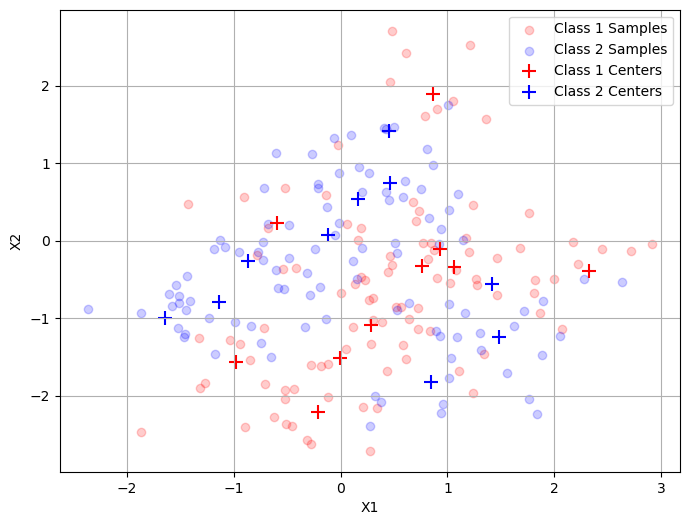

In [4]:
plt.figure(figsize=(8, 6))

plt.scatter(Xtrain[Ytrain == 0, 0], Xtrain[Ytrain == 0, 1], color='red', alpha=0.2, label='Class 1 Samples')
plt.scatter(Xtrain[Ytrain == 1, 0], Xtrain[Ytrain == 1, 1], color='blue', alpha=0.2, label='Class 2 Samples')

# Plot the centers with a '+' marker
plt.scatter(centers[0][:,0], centers[0][:,1], color='red', marker='+', s=100, label='Class 1 Centers')
plt.scatter(centers[1][:,0], centers[1][:,1], color='blue', marker='+', s=100, label='Class 2 Centers')

# Add legend and labels
plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()


### Part 2: kNN

In [5]:
def knn(X_Y_train, X_test, k):
    X_train, Y_train = X_Y_train

    u = np.sum(X_train ** 2, axis=1)
    v = np.sum(X_test ** 2, axis=1)
    B = X_train @ X_test.T

    # Using formula from this post https://campuswire.com/c/GB46E5679/feed/45
    D = u[:, np.newaxis] - (2 * B) + v
    # D[i, j] is squared distance from i-th train point to j-th test point

    # Using stable sort, so equidistant points will get sorted in the order they appear in the data 
    sort_order = np.argsort(D, axis=0, kind='stable')
    Y_knn = np.take_along_axis(Y_train[:, np.newaxis], sort_order[:k, :], axis=0)
    
    counts = np.sum(Y_knn, axis=0)
    Y_test = (counts > k / 2).astype(int)
    # Breaking voting ties, by assigning it the label of the closest point
    Y_test[counts == k / 2] = Y_knn[0, counts == k / 2]

    return Y_test


In [6]:
def run_sklearn_knn(X_Y_train, X_test, k):
    X_train, Y_train = X_Y_train
    knn_model = skl_knn(n_neighbors=k)
    knn_model.fit(X_train, Y_train)
    return knn_model.predict(X_test)

Distance ties: We pick the training data that occurs first in the dataset (by using a stable sort)

Voting ties: We assign the class label of the closest point

k=1 error rate: myknn: 0.3253 skl_knn: 0.3253
k=3 error rate: myknn: 0.293 skl_knn: 0.293
k=5 error rate: myknn: 0.2759 skl_knn: 0.2759


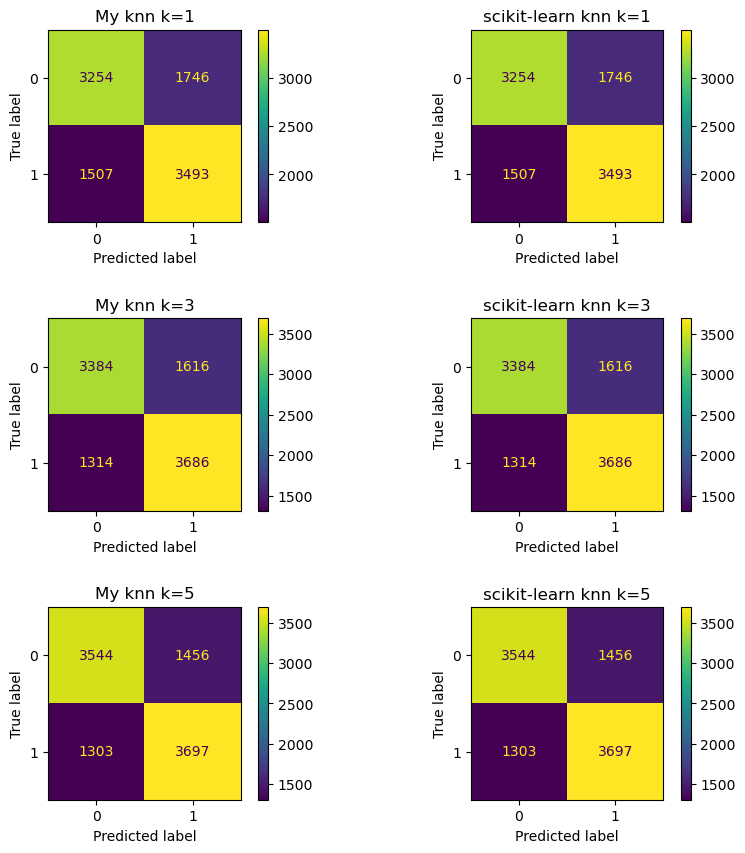

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

fig.subplots_adjust(hspace=0.5)

for k, ax in zip([1, 3, 5], axes):
    Ypred = knn((Xtrain, Ytrain), Xtest, k)
    confusion_matrix = metrics.confusion_matrix(Ytest, Ypred)
    cm_display = metrics.ConfusionMatrixDisplay.from_predictions(Ytest, Ypred, display_labels = [0, 1], ax=ax[0])
    ax[0].set_title(f'My knn k={k}')
    
    Ypred_skl = run_sklearn_knn((Xtrain, Ytrain), Xtest, k)
    cm_display = metrics.ConfusionMatrixDisplay.from_predictions(Ytest, Ypred_skl, display_labels = [0, 1], ax=ax[1])
    ax[1].set_title(f'scikit-learn knn k={k}')

    print(f"k={k} error rate: myknn: {np.mean(Ypred != Ytest)} skl_knn: {np.mean(Ypred_skl != Ytest)}")

plt.show()

### Part 3: cvKNN

In [8]:
# Referenced cross-validation code from https://liangfgithub.github.io/Python_W1_SimulationStudy.html

def cvknn_choose_k(X_Y_train, max_k):
    num_folds = 10
    X_train, Y_train = X_Y_train
    n = len(Y_train)
    cverr = np.zeros(max_k)

    indices = np.arange(n)
    np.random.shuffle(indices)
    index_sets = np.array_split(indices, num_folds)

    for ifold in range(num_folds):
        train_indices =  np.delete(index_sets, obj=ifold, axis=0).ravel()
        _traindata = X_train[train_indices]
        _Ytrain = Y_train[train_indices]
        
        test_indices = index_sets[ifold]
        _testdata = X_train[test_indices]
        _Ytest = Y_train[test_indices]
    
        for K in range(1, max_k + 1):
            predict_Y = run_sklearn_knn((_traindata, _Ytrain), _testdata, K)
            cverr[K - 1] += sum(predict_Y != _Ytest)
        
    best_k = np.nonzero(cverr == np.min(cverr))[0][-1] + 1
    return best_k


def cvknn(X_Y_train, max_k, X_test):
    k = cvknn_choose_k(X_Y_train, max_k)
    return k, run_sklearn_knn(X_Y_train, X_test, k)

# With 200 examples and 10-fold cv, there will be 180 train examples per cv step, hence setting max_k to 180
k, Ypred = cvknn((Xtrain, Ytrain), 180, Xtest)


The best choice for k is 17
test error rate: 0.2614


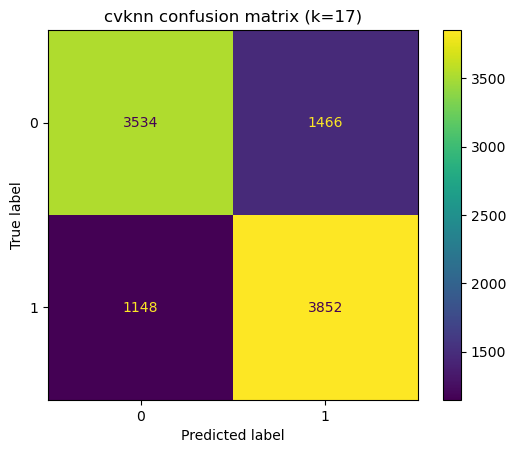

In [9]:

print(f"The best choice for k is {k}")
print(f"test error rate: {np.mean(Ytest != Ypred)}")
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(Ytest, Ypred, display_labels = [0, 1])
cm_display.ax_.set_title(f'cvknn confusion matrix (k={k})')
plt.show()

### Part 4: Bayes rule

error rate: 0.2295


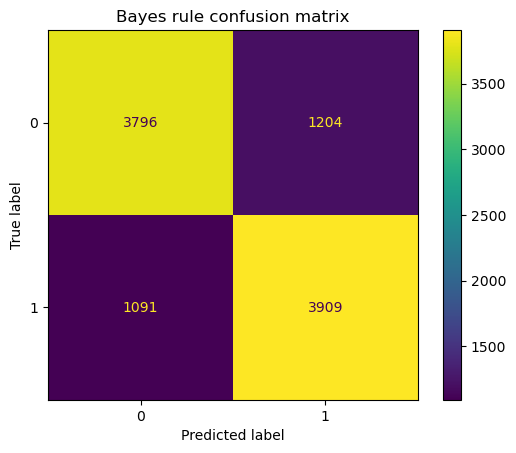

In [10]:
def bayes(X_test, centers, variance):
    def exp_sum(m):
        u = np.sum(X_test ** 2, axis=1)
        v = np.sum(m ** 2, axis=1)
        B = X_test @ m.T
        
        # Using formula from this post https://campuswire.com/c/GB46E5679/feed/45
        D = u[:, np.newaxis] - (2 * B) + v
        return np.sum(np.exp(-D / (2 * variance)), axis=1)

    return (exp_sum(centers[1]) >= exp_sum(centers[0])).astype(int)

Ypred = bayes(Xtest, centers, variance)
print(f"error rate: {np.mean(Ypred != Ytest)}")
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(Ytest, Ypred, display_labels = [0, 1])
cm_display.ax_.set_title(f'Bayes rule confusion matrix')
plt.show()

### Part 5: Simulation Study

In [11]:
n_sims = 50

knn_errors = np.zeros(n_sims)
cvknn_errors = np.zeros(n_sims)
bayes_errors = np.zeros(n_sims)

best_ks = np.zeros(n_sims)

def calc_error(actual, pred):
    return np.mean(actual != pred)

for idx in trange(n_sims):
    Xtrain, Ytrain = generate_data_matrices(centers, 200)
    Xtest, Ytest = generate_data_matrices(centers, 10000)

    knn_errors[idx] = calc_error(Ytest, run_sklearn_knn((Xtrain, Ytrain), Xtest, 7))
    
    best_k, cv_knn_pred = cvknn((Xtrain, Ytrain), 180, Xtest)
    best_ks[idx] = best_k
    cvknn_errors[idx] = calc_error(Ytest, cv_knn_pred)

    bayes_errors[idx] = calc_error(Ytest, bayes(Xtest, centers, variance))

  0%|          | 0/50 [00:00<?, ?it/s]

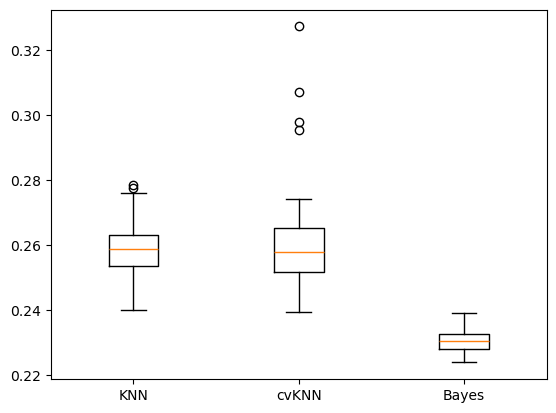

In [12]:
plt.boxplot([knn_errors, cvknn_errors, bayes_errors], labels=['KNN', 'cvKNN', 'Bayes'])
plt.show()

### Numerical Summary

In [13]:
five_number_summary = np.percentile(best_ks, [0, 25, 50, 75, 100])

print("Five-number-summary of best K values")
dict(zip(['min', '25% quantile', 'median', '75% quantile', 'max'], five_number_summary))
                          

Five-number-summary of best K values


{'min': 2.0,
 '25% quantile': 7.0,
 'median': 9.0,
 '75% quantile': 12.75,
 'max': 31.0}